# Real Estate Price Prediction
## Geekbrains AI/BigData Python for Data Science course competition

https://www.kaggle.com/c/realestatepriceprediction/leaderboard

**Files description**   
train.csv - the training set   
test.csv - the test set   
   
**Data fields**   
Id - идентификационный номер квартиры   
DistrictId - идентификационный номер района   
Rooms - количество комнат   
Square - площадь   
LifeSquare - жилая площадь   
KitchenSquare - площадь кухни   
Floor - этаж   
HouseFloor - количество этажей в доме   
HouseYear - год постройки дома   
Ecology_1, Ecology_2, Ecology_3 - экологические показатели местности   
Social_1, Social_2, Social_3 - социальные показатели местности   
Healthcare_1, Helthcare_2 - показатели местности, связанные с охраной здоровья   
Shops_1, Shops_2 - показатели, связанные с наличием магазинов, торговых центров   
Price - цена квартиры   

**Loading up libraries**

In [1]:
import numpy as np
import pandas as pd

from sklearn.linear_model import LinearRegression, Lasso, Ridge, LassoCV, RidgeCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import KFold, GridSearchCV, RandomizedSearchCV

import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import boxcox, probplot

from sklearn.metrics import mean_squared_error, r2_score

from catboost import Pool, CatBoostRegressor
import xgboost as xgb

import warnings
warnings.simplefilter('ignore')

**The Path**

In [2]:
# input
TRAIN_DATASET_PATH = 'train.csv'
TEST_DATASET_PATH = 'test.csv'

### Loading the data

In [3]:
train = pd.read_csv(TRAIN_DATASET_PATH)

In [4]:
test = pd.read_csv(TEST_DATASET_PATH)

In [5]:
train.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
0,14038,35,2.0,47.981561,29.442751,6.0,7,9.0,1969,0.089040,B,B,33,7976,5,NaN,0,11,B,184966.930730
1,15053,41,3.0,65.683640,40.049543,8.0,7,9.0,1978,0.000070,B,B,46,10309,1,240.0,1,16,B,300009.450063
2,4765,53,2.0,44.947953,29.197612,0.0,8,12.0,1968,0.049637,B,B,34,7759,0,229.0,1,3,B,220925.908524
3,5809,58,2.0,53.352981,52.731512,9.0,8,17.0,1977,0.437885,B,B,23,5735,3,1084.0,0,5,B,175616.227217
4,10783,99,1.0,39.649192,23.776169,7.0,11,12.0,1976,0.012339,B,B,35,5776,1,2078.0,2,4,B,150226.531644


In [6]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 20 columns):
Id               10000 non-null int64
DistrictId       10000 non-null int64
Rooms            10000 non-null float64
Square           10000 non-null float64
LifeSquare       7887 non-null float64
KitchenSquare    10000 non-null float64
Floor            10000 non-null int64
HouseFloor       10000 non-null float64
HouseYear        10000 non-null int64
Ecology_1        10000 non-null float64
Ecology_2        10000 non-null object
Ecology_3        10000 non-null object
Social_1         10000 non-null int64
Social_2         10000 non-null int64
Social_3         10000 non-null int64
Healthcare_1     5202 non-null float64
Helthcare_2      10000 non-null int64
Shops_1          10000 non-null int64
Shops_2          10000 non-null object
Price            10000 non-null float64
dtypes: float64(8), int64(9), object(3)
memory usage: 1.5+ MB


#### Пропущенные данные

In [7]:
len(train) - train.count()

Id                  0
DistrictId          0
Rooms               0
Square              0
LifeSquare       2113
KitchenSquare       0
Floor               0
HouseFloor          0
HouseYear           0
Ecology_1           0
Ecology_2           0
Ecology_3           0
Social_1            0
Social_2            0
Social_3            0
Healthcare_1     4798
Helthcare_2         0
Shops_1             0
Shops_2             0
Price               0
dtype: int64

In [8]:
len(test) - test.count()

Id                  0
DistrictId          0
Rooms               0
Square              0
LifeSquare       1041
KitchenSquare       0
Floor               0
HouseFloor          0
HouseYear           0
Ecology_1           0
Ecology_2           0
Ecology_3           0
Social_1            0
Social_2            0
Social_3            0
Healthcare_1     2377
Helthcare_2         0
Shops_1             0
Shops_2             0
dtype: int64

## Обзор целевой переменной

### 'Price'

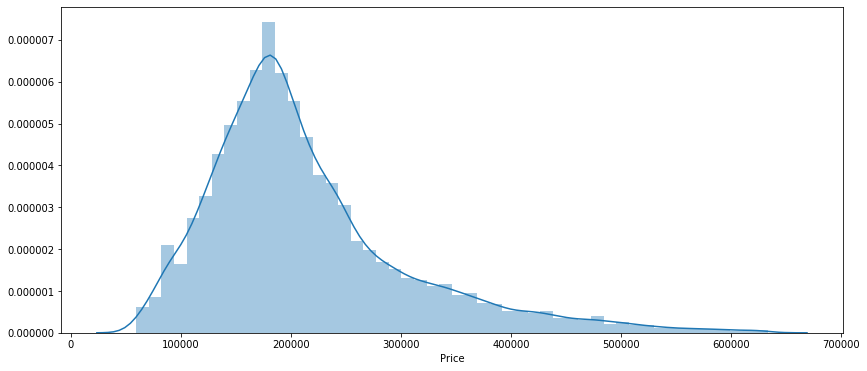

In [9]:
plt.figure(figsize=(14, 6))
sns.distplot(train.Price);

#### QQ plot для сравнения с нормальным распределением

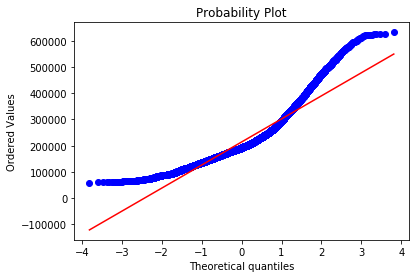

In [10]:
f, ax = plt.subplots()
probplot(train['Price'], plot=ax);

#### Преобразование логарифм

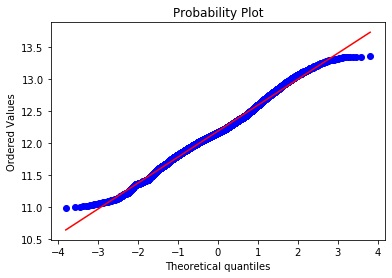

In [11]:
f, ax = plt.subplots()
probplot(np.log(train['Price']), plot=ax);

#### Преобразование Бокса-Кокса

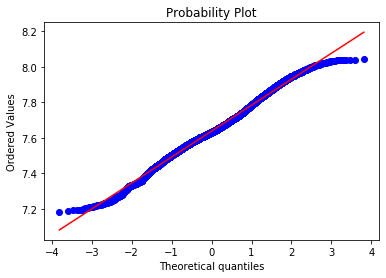

In [12]:
f, ax = plt.subplots()
probplot(boxcox(train['Price'])[0], plot=ax);

In [13]:
train.loc[train['Price'] < train['Price'].quantile(.001)]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
1034,13715,91,2.0,41.881139,25.494645,7.0,6,9.0,1970,0.000995,B,B,42,7651,1,NaN,1,5,B,62483.977998
1148,1575,23,1.0,33.555591,33.330277,1.0,5,9.0,2014,0.034656,B,B,0,168,0,NaN,0,0,B,61670.348212
1622,11854,9,2.0,55.126426,29.914386,8.0,4,14.0,2004,0.130123,B,B,8,1986,0,NaN,0,0,B,62126.665619
3605,7243,9,2.0,58.089253,52.460857,8.0,5,22.0,1981,0.136244,B,B,11,2370,0,NaN,0,1,B,59877.592523
6856,2648,23,1.0,34.670830,NaN,0.0,4,0.0,1977,0.005767,B,B,1,388,0,NaN,0,0,B,60828.260686
7850,8800,23,1.0,29.706031,NaN,0.0,5,12.0,1977,0.034656,B,B,0,168,0,NaN,0,0,B,60502.583500
8444,2950,23,1.0,27.778509,26.715238,0.0,5,4.0,2017,0.034656,B,B,0,168,0,NaN,0,0,B,60918.567890
8957,9042,23,1.0,32.233290,NaN,0.0,3,4.0,1977,0.034656,B,B,0,168,0,NaN,0,0,B,62225.023069
9732,13237,144,2.0,51.726692,30.547287,8.0,2,14.0,1988,0.306977,B,B,27,5148,14,1575.0,5,7,B,59174.778028
9961,1579,23,1.0,27.331108,NaN,1.0,10,12.0,1977,0.034656,B,B,0,168,0,NaN,0,0,B,60825.032060


In [14]:
train.loc[train['Price'] > train['Price'].quantile(.999)]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
1537,3206,54,3.0,125.117838,NaN,1.0,4,1.0,1977,0.006076,B,B,30,5285,0,645.0,6,6,B,625820.041178
3228,15192,26,3.0,117.714551,57.440648,15.0,17,30.0,2012,0.000000,B,B,36,6714,2,2672.0,0,2,B,624680.099059
4487,13434,13,5.0,183.382273,100.985505,15.0,2,6.0,1997,0.090799,B,B,74,19083,2,NaN,5,15,B,622888.825328
4764,11013,43,2.0,58.757047,34.605286,8.0,12,17.0,2004,0.000078,B,B,22,6398,141,1046.0,3,23,B,625678.644994
5494,300,31,2.0,106.427686,34.230415,32.0,4,40.0,2013,0.151346,B,A,32,5889,10,830.0,4,1,B,624549.354546
5743,98,54,3.0,120.890731,120.968324,1.0,7,1.0,2015,0.006076,B,B,30,5285,0,645.0,6,6,B,621002.912679
6794,13226,73,2.0,73.210349,NaN,1.0,16,17.0,2019,0.042032,B,B,37,6856,84,1940.0,2,5,B,633233.466570
8143,15251,17,3.0,125.017368,NaN,0.0,24,0.0,1977,0.093443,B,B,23,4635,5,3300.0,2,4,B,627525.072788
8501,7275,95,4.0,99.039161,71.575839,11.0,2,3.0,1942,0.000699,B,B,14,3369,24,4129.0,0,3,B,624156.003381
9650,6323,162,3.0,93.815902,61.816690,9.0,6,6.0,1952,0.174739,B,B,17,3379,9,100.0,0,3,B,624008.535763


In [15]:
# train = train.loc[train['Price'] < train['Price'].quantile(.99)]

## Формирование списков признаков, обработка выбросов и пропусков, приведение типов

In [16]:
num_features = train.select_dtypes(include=['int64', 'float64']).columns.drop(['Price', 'Id', 'DistrictId']).to_list()
num_features

['Rooms',
 'Square',
 'LifeSquare',
 'KitchenSquare',
 'Floor',
 'HouseFloor',
 'HouseYear',
 'Ecology_1',
 'Social_1',
 'Social_2',
 'Social_3',
 'Healthcare_1',
 'Helthcare_2',
 'Shops_1']

In [17]:
feats = ['Square',
 'KitchenSquare',
 'Floor',
 'HouseFloor',
 'HouseYear',
 ]

In [18]:
for col in num_features:
    train.loc[train[col] > train[col].quantile(.999), col] = train[col].quantile(.999)
    train.loc[train[col] < train[col].quantile(.001), col] = train[col].quantile(.001)
    test.loc[test[col] > train[col].quantile(.999), col] = train[col].quantile(.999)
    test.loc[test[col] < train[col].quantile(.001), col] = train[col].quantile(.001)

In [19]:
train.describe()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Price
count,10000.00000,10000.000000,10000.000000,10000.000000,7887.000000,10000.000000,10000.000000,10000.000000,10000.00000,10000.000000,10000.000000,10000.000000,10000.000000,5202.000000,10000.000000,10000.000000,10000.000000
mean,8383.40770,50.400800,1.888800,56.190261,36.124965,5.871601,8.521900,12.586700,1984.87530,0.118858,24.687000,5352.157400,8.039200,1142.910227,1.319500,4.231300,214138.857399
std,4859.01902,43.587592,0.813819,19.134096,18.051164,4.964606,5.220081,6.584726,18.40538,0.119025,17.532614,4006.799803,23.831875,1021.510895,1.493601,4.806341,92872.293865
min,0.00000,0.000000,1.000000,5.128916,1.140953,0.000000,1.000000,0.000000,1918.00000,0.000000,0.000000,168.000000,0.000000,30.000000,0.000000,0.000000,59174.778028
25%,4169.50000,20.000000,1.000000,41.774881,22.769832,1.000000,4.000000,9.000000,1974.00000,0.017647,6.000000,1564.000000,0.000000,350.000000,0.000000,1.000000,153872.633942
50%,8394.50000,36.000000,2.000000,52.513310,32.781260,6.000000,7.000000,13.000000,1977.00000,0.075424,25.000000,5285.000000,2.000000,900.000000,1.000000,3.000000,192269.644879
75%,12592.50000,75.000000,2.000000,65.900625,45.128803,9.000000,12.000000,17.000000,2001.00000,0.195781,36.000000,7227.000000,5.000000,1548.000000,2.000000,6.000000,249135.462171
max,16798.00000,209.000000,5.000000,183.384797,177.891174,72.001000,27.000000,40.000000,2020.00000,0.521867,74.000000,19083.000000,141.000000,4849.000000,6.000000,23.000000,633233.466570


In [20]:
test.describe()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1
count,5000.000000,5000.000000,5000.000000,5000.000000,3959.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,2623.000000,5000.00000,5000.000000
mean,8412.595400,51.279200,1.907600,56.435588,36.127011,5.854200,8.610200,12.584400,1984.401600,0.119874,24.933800,5406.900000,8.262600,1146.668700,1.31940,4.242800
std,4832.674037,44.179466,0.809687,18.956272,17.452454,4.719936,5.349503,6.666976,18.539068,0.120070,17.532202,4026.614773,23.863762,1044.731838,1.47994,4.777365
min,1.000000,0.000000,1.000000,5.129221,1.141099,0.000000,1.000000,0.000000,1918.000000,0.000000,0.000000,168.000000,0.000000,30.000000,0.00000,0.000000
25%,4221.750000,21.000000,1.000000,41.906231,23.092026,1.000000,4.000000,9.000000,1973.000000,0.019509,6.000000,1564.000000,0.000000,325.000000,0.00000,1.000000
50%,8320.500000,37.000000,2.000000,52.921340,32.925087,6.000000,7.000000,12.000000,1977.000000,0.072158,25.000000,5285.000000,2.000000,900.000000,1.00000,3.000000
75%,12598.250000,77.000000,2.000000,66.285129,45.174091,9.000000,12.000000,17.000000,2000.000000,0.195781,36.000000,7287.000000,5.000000,1548.000000,2.00000,6.000000
max,16795.000000,212.000000,5.000000,183.382275,175.185249,72.000001,27.000000,40.000000,2020.000000,0.521867,74.000000,19083.000000,141.000000,4849.000000,6.00000,23.000000


In [21]:
cat_features = train.select_dtypes(include=['object']).columns.to_list()
cat_features

['Ecology_2', 'Ecology_3', 'Shops_2']

### 'DistrictId'

In [22]:
train.DistrictId.nunique()

205

In [23]:
train.DistrictId.value_counts()

27     851
1      652
23     565
6      511
9      294
      ... 
199      1
205      1
174      1
209      1
207      1
Name: DistrictId, Length: 205, dtype: int64

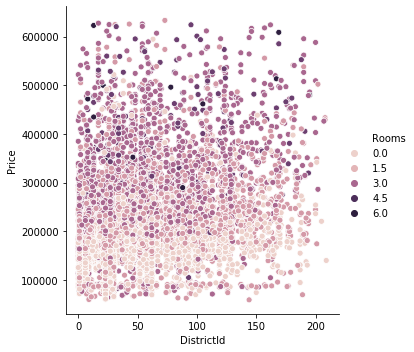

In [24]:
sns.relplot(x="DistrictId", y="Price", hue="Rooms", data=train);

### 'Rooms'

In [25]:
train.loc[train['Rooms'] > 5, 'Rooms'] = 5

In [26]:
test.loc[test['Rooms'] > 5, 'Rooms'] = 5

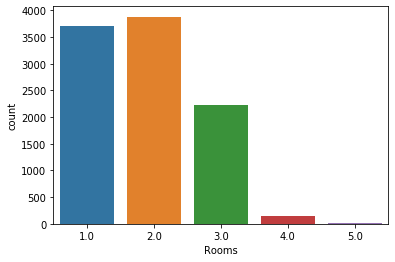

In [27]:
sns.countplot(train.Rooms);

In [28]:
train['Rooms'] = train['Rooms'].astype('int')
test['Rooms'] = test['Rooms'].astype('int')

### Создадим признак "квадрат количества комнат"

In [29]:
# train['Rooms_sqr'] = train['Rooms'] ** 2
# test['Rooms_sqr'] = test['Rooms'] ** 2

### Создадим признак "средняя цена квартиры в зависимости от района и количества комнат"

In [30]:
mean_price = pd.DataFrame(train.groupby(['DistrictId', 'Rooms'])['Price'].mean())

In [31]:
mean_price = mean_price.rename(columns={'Price': 'MeanPrice'}). reset_index()

In [32]:
train = train.merge(mean_price, on=['DistrictId', 'Rooms'])
test = test.merge(mean_price, on=['DistrictId', 'Rooms'], how='left')

In [33]:
test.MeanPrice.isnull().sum()

64

In [34]:
for i in range(5):
    test.loc[(test['MeanPrice'].isnull()) & (test['Rooms'] == i+1)] = test.loc[
        (test['MeanPrice'].isnull()) & (test['Rooms'] == i+1)
    ].fillna(train.loc[train['Rooms'] == i+1, 'MeanPrice'].mean())

### 'Square'

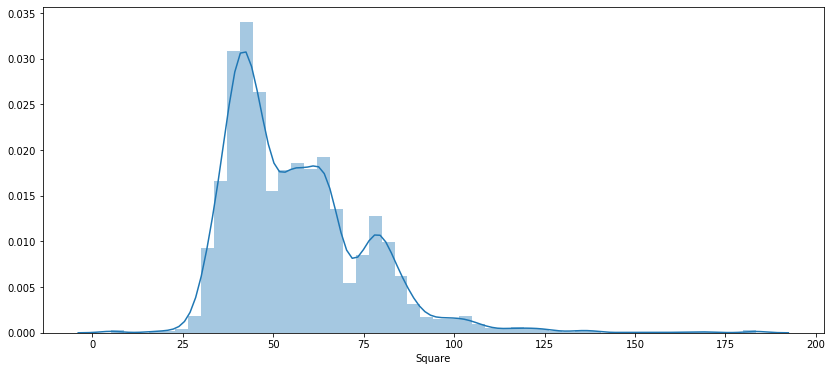

In [35]:
plt.figure(figsize=(14, 6))
sns.distplot(train.Square);

### 'LifeSquare'

In [36]:
train['LifeSquare'] = train['LifeSquare'].fillna(1000.0)
train.loc[train['LifeSquare'] > train['Square'], 'LifeSquare'] = train['Square']
train.loc[train['LifeSquare'] < 10, 'LifeSquare'] = train['Square']

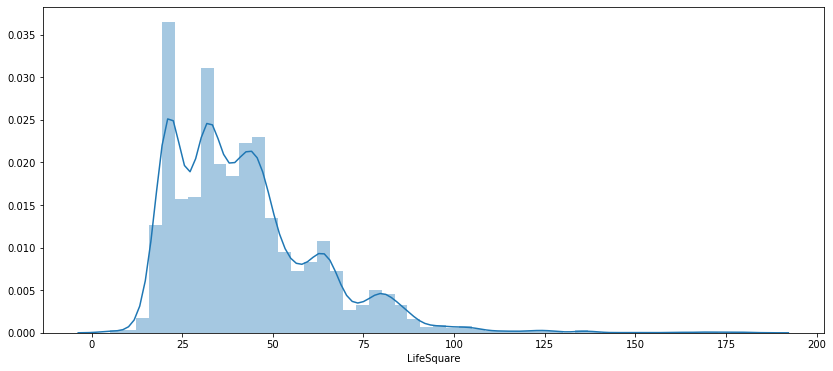

In [37]:
plt.figure(figsize=(14, 6))
sns.distplot(train.LifeSquare);

In [38]:
test['LifeSquare'] = test['LifeSquare'].fillna(1000.0)
test.loc[test['LifeSquare'] > test['Square'], 'LifeSquare'] = test['Square']
test.loc[test['LifeSquare'] < 10, 'LifeSquare'] = test['Square']

### 'KitchenSquare'

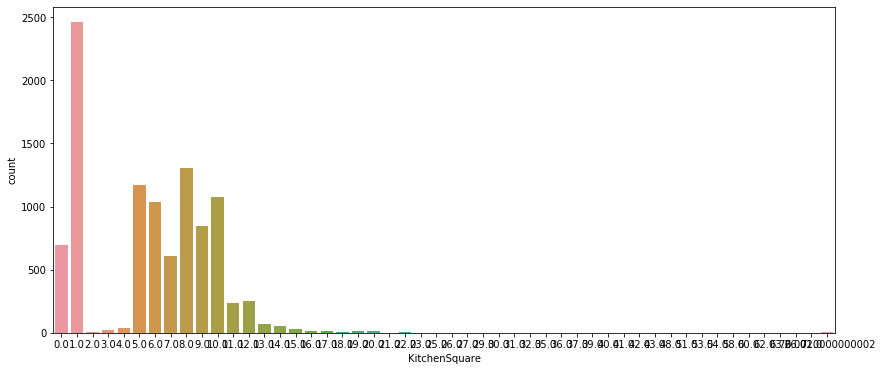

In [39]:
plt.figure(figsize=(14, 6))
sns.countplot(train.KitchenSquare);

In [40]:
train['KitchenSquare'] = train['KitchenSquare'].astype('int')
test['KitchenSquare'] = test['KitchenSquare'].astype('int')

### 'Floor'

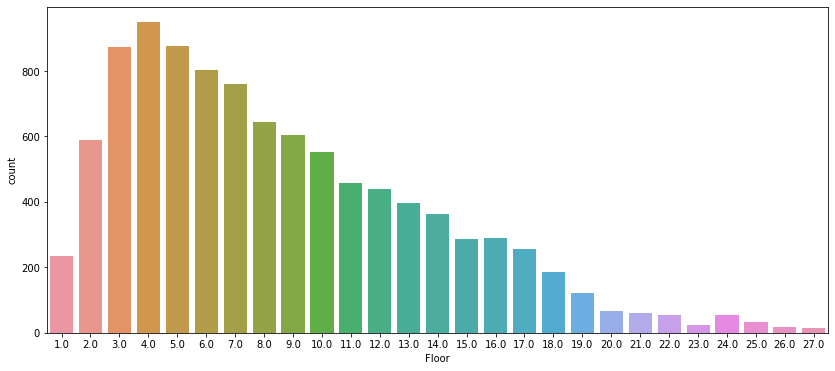

In [41]:
plt.figure(figsize=(14, 6))
sns.countplot(train.Floor);

In [42]:
train['Floor'] = train['Floor'].astype('int')
test['Floor'] = test['Floor'].astype('int')

### 'IsGroundFloor'

In [43]:
train['IsGroundFloor'] = 0
train.loc[train['Floor'] == 1, 'IsGroundFloor'] = 1

In [44]:
test['IsGroundFloor'] = 0
test.loc[test['Floor'] == 1, 'IsGroundFloor'] = 1

### 'HouseFloor'

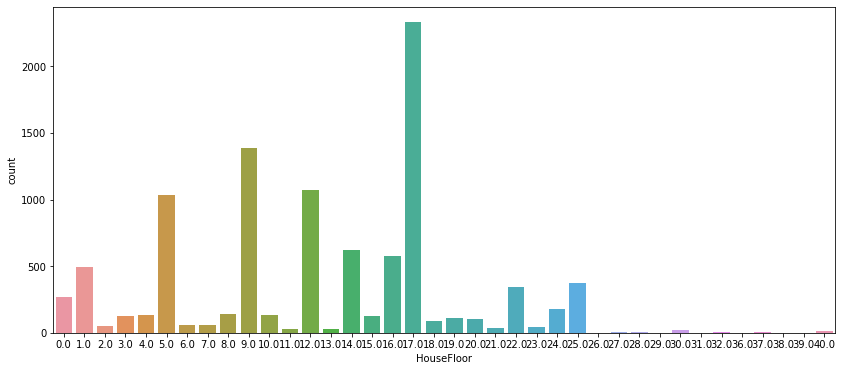

In [45]:
plt.figure(figsize=(14, 6))
sns.countplot(train.HouseFloor);

In [46]:
train.loc[train['HouseFloor'] == 0.0, 'HouseFloor'] = 1

In [47]:
test.loc[train['HouseFloor'] == 0.0, 'HouseFloor'] = 1

In [48]:
train['HouseFloor'] = train['HouseFloor'].astype('int')
test['HouseFloor'] = test['HouseFloor'].astype('int')

### 'IsUpperFloor'

In [49]:
train['IsUpperFloor'] = 0
train.loc[train['Floor'] == train['HouseFloor'], 'IsUpperFloor'] = 1

In [50]:
test['IsUpperFloor'] = 0
test.loc[test['Floor'] == test['HouseFloor'], 'IsUpperFloor'] = 1

### 'HouseYear'

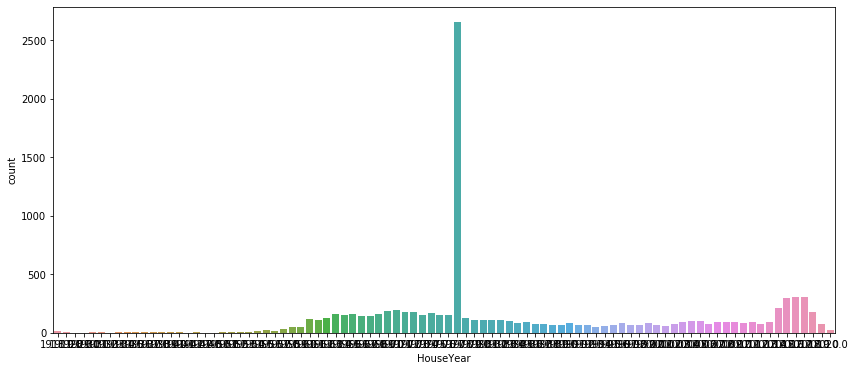

In [51]:
plt.figure(figsize=(14, 6))
sns.countplot(train.HouseYear);

In [52]:
train['HouseYear'] = train['HouseYear'].astype('int')
test['HouseYear'] = test['HouseYear'].astype('int')

### 'Ecology_1'

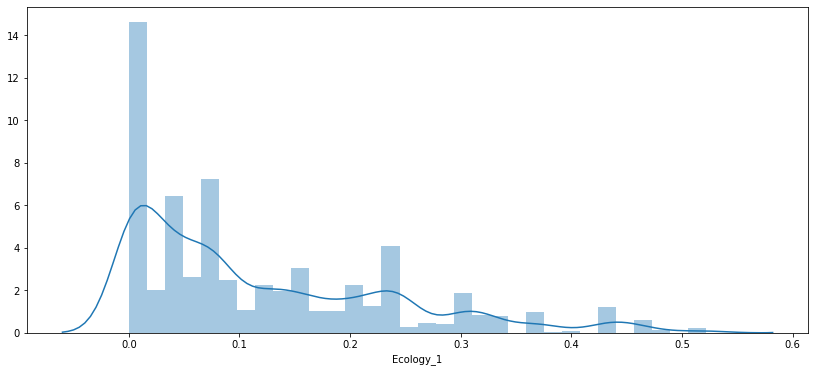

In [53]:
plt.figure(figsize=(14, 6))
sns.distplot(train.Ecology_1);

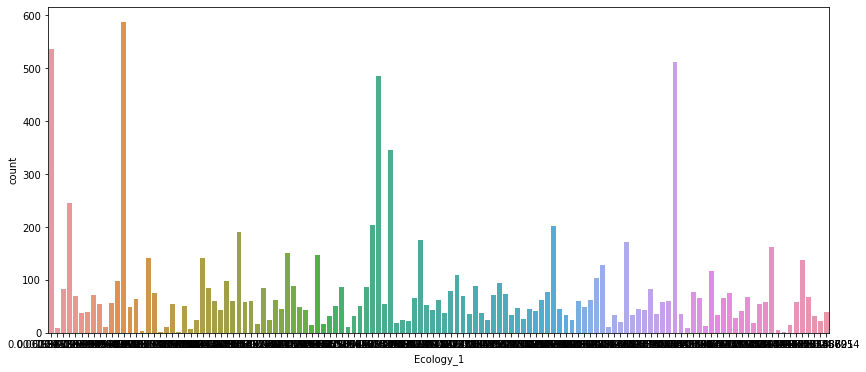

In [54]:
plt.figure(figsize=(14, 6))
sns.countplot(train.Ecology_1);

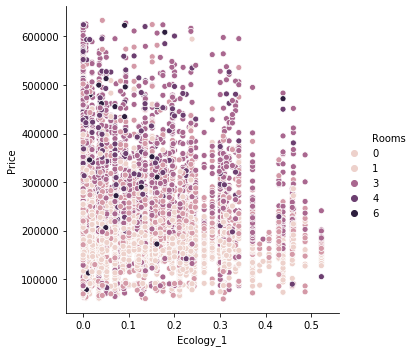

In [55]:
sns.relplot(x="Ecology_1", y="Price", hue="Rooms", data=train);

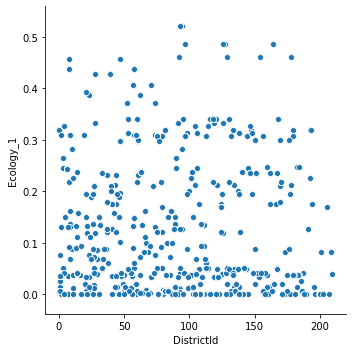

In [56]:
sns.relplot(x="DistrictId", y="Ecology_1", data=train);

### 'Healthcare_1'

In [57]:
healthcare_test = train.loc[train['Healthcare_1'].isnull()].drop('Price', axis=1)

In [58]:
healthcare_train = train.loc[train['Healthcare_1'].notnull()].drop('Price', axis=1)

In [59]:
train_pool = Pool(healthcare_train.drop('Healthcare_1', axis=1), 
                  healthcare_train.Healthcare_1, 
                  cat_features=cat_features)

In [60]:
filling_drops = CatBoostRegressor(cat_features=cat_features)

In [61]:
filling_drops.fit(train_pool)

0:	learn: 1006.6131996	total: 69.2ms	remaining: 1m 9s
1:	learn: 992.8619683	total: 72.6ms	remaining: 36.2s
2:	learn: 980.9523391	total: 75.8ms	remaining: 25.2s
3:	learn: 966.9014356	total: 79.1ms	remaining: 19.7s
4:	learn: 952.7416060	total: 82.1ms	remaining: 16.3s
5:	learn: 939.4044776	total: 85.3ms	remaining: 14.1s
6:	learn: 926.0460509	total: 88.5ms	remaining: 12.6s
7:	learn: 913.6700697	total: 92.3ms	remaining: 11.4s
8:	learn: 901.6089758	total: 95.3ms	remaining: 10.5s
9:	learn: 892.4650974	total: 98.5ms	remaining: 9.75s
10:	learn: 880.6533755	total: 102ms	remaining: 9.15s
11:	learn: 869.1156643	total: 105ms	remaining: 8.63s
12:	learn: 858.0646244	total: 108ms	remaining: 8.2s
13:	learn: 848.8955270	total: 111ms	remaining: 7.83s
14:	learn: 838.5639633	total: 114ms	remaining: 7.51s
15:	learn: 830.9484216	total: 117ms	remaining: 7.22s
16:	learn: 820.0717129	total: 120ms	remaining: 6.96s
17:	learn: 809.7557866	total: 124ms	remaining: 6.74s
18:	learn: 800.8218954	total: 126ms	remaining:

187:	learn: 204.7505213	total: 953ms	remaining: 4.12s
188:	learn: 203.0425861	total: 959ms	remaining: 4.12s
189:	learn: 201.7691479	total: 964ms	remaining: 4.11s
190:	learn: 200.5727325	total: 968ms	remaining: 4.1s
191:	learn: 199.4223751	total: 971ms	remaining: 4.09s
192:	learn: 198.2570798	total: 976ms	remaining: 4.08s
193:	learn: 196.3111182	total: 979ms	remaining: 4.07s
194:	learn: 194.9259425	total: 982ms	remaining: 4.05s
195:	learn: 193.8169923	total: 1.01s	remaining: 4.15s
196:	learn: 192.6188720	total: 1.01s	remaining: 4.14s
197:	learn: 191.7606463	total: 1.02s	remaining: 4.12s
198:	learn: 190.8676773	total: 1.02s	remaining: 4.11s
199:	learn: 189.7068453	total: 1.02s	remaining: 4.1s
200:	learn: 188.7734033	total: 1.03s	remaining: 4.09s
201:	learn: 187.5142142	total: 1.03s	remaining: 4.08s
202:	learn: 186.5790160	total: 1.03s	remaining: 4.06s
203:	learn: 185.2677133	total: 1.04s	remaining: 4.05s
204:	learn: 184.2574366	total: 1.07s	remaining: 4.17s
205:	learn: 183.2106493	total:

342:	learn: 86.8393408	total: 1.83s	remaining: 3.5s
343:	learn: 86.4566692	total: 1.83s	remaining: 3.5s
344:	learn: 85.8131729	total: 1.84s	remaining: 3.49s
345:	learn: 85.3296063	total: 1.84s	remaining: 3.48s
346:	learn: 85.0067990	total: 1.84s	remaining: 3.47s
347:	learn: 84.7141524	total: 1.84s	remaining: 3.46s
348:	learn: 84.2983912	total: 1.85s	remaining: 3.45s
349:	learn: 83.8759166	total: 1.85s	remaining: 3.44s
350:	learn: 83.2841774	total: 1.85s	remaining: 3.43s
351:	learn: 82.7434543	total: 1.88s	remaining: 3.46s
352:	learn: 82.3427269	total: 1.89s	remaining: 3.46s
353:	learn: 82.0593549	total: 1.89s	remaining: 3.45s
354:	learn: 81.7909702	total: 1.89s	remaining: 3.44s
355:	learn: 81.2038462	total: 1.89s	remaining: 3.43s
356:	learn: 80.7599368	total: 1.9s	remaining: 3.42s
357:	learn: 80.3146043	total: 1.9s	remaining: 3.41s
358:	learn: 80.0847123	total: 1.91s	remaining: 3.4s
359:	learn: 79.5290475	total: 1.93s	remaining: 3.43s
360:	learn: 79.2642018	total: 1.93s	remaining: 3.42

509:	learn: 44.8759675	total: 2.73s	remaining: 2.62s
510:	learn: 44.6861612	total: 2.73s	remaining: 2.61s
511:	learn: 44.6037691	total: 2.73s	remaining: 2.6s
512:	learn: 44.5414391	total: 2.74s	remaining: 2.6s
513:	learn: 44.4074158	total: 2.74s	remaining: 2.59s
514:	learn: 44.2972534	total: 2.74s	remaining: 2.58s
515:	learn: 44.2186204	total: 2.75s	remaining: 2.58s
516:	learn: 43.9950564	total: 2.76s	remaining: 2.58s
517:	learn: 43.9394237	total: 2.76s	remaining: 2.57s
518:	learn: 43.7929283	total: 2.76s	remaining: 2.56s
519:	learn: 43.5816178	total: 2.77s	remaining: 2.55s
520:	learn: 43.4342689	total: 2.77s	remaining: 2.55s
521:	learn: 43.3300433	total: 2.77s	remaining: 2.54s
522:	learn: 43.2738778	total: 2.78s	remaining: 2.53s
523:	learn: 43.1112675	total: 2.78s	remaining: 2.52s
524:	learn: 43.0644026	total: 2.78s	remaining: 2.52s
525:	learn: 42.9413227	total: 2.79s	remaining: 2.51s
526:	learn: 42.8415460	total: 2.79s	remaining: 2.5s
527:	learn: 42.7861340	total: 2.79s	remaining: 2.

696:	learn: 28.2531656	total: 3.62s	remaining: 1.57s
697:	learn: 28.1909032	total: 3.63s	remaining: 1.57s
698:	learn: 28.1362491	total: 3.63s	remaining: 1.56s
699:	learn: 28.1107483	total: 3.63s	remaining: 1.56s
700:	learn: 28.0771359	total: 3.64s	remaining: 1.55s
701:	learn: 28.0448476	total: 3.64s	remaining: 1.54s
702:	learn: 28.0113722	total: 3.65s	remaining: 1.54s
703:	learn: 27.9790303	total: 3.65s	remaining: 1.53s
704:	learn: 27.9364833	total: 3.66s	remaining: 1.53s
705:	learn: 27.8893866	total: 3.66s	remaining: 1.52s
706:	learn: 27.8594431	total: 3.66s	remaining: 1.52s
707:	learn: 27.7915518	total: 3.67s	remaining: 1.51s
708:	learn: 27.7720911	total: 3.67s	remaining: 1.51s
709:	learn: 27.7605363	total: 3.67s	remaining: 1.5s
710:	learn: 27.6824244	total: 3.68s	remaining: 1.49s
711:	learn: 27.5644700	total: 3.68s	remaining: 1.49s
712:	learn: 27.4849757	total: 3.69s	remaining: 1.48s
713:	learn: 27.4515302	total: 3.69s	remaining: 1.48s
714:	learn: 27.4263545	total: 3.7s	remaining: 1

859:	learn: 21.4126094	total: 4.5s	remaining: 733ms
860:	learn: 21.3746043	total: 4.51s	remaining: 728ms
861:	learn: 21.3496554	total: 4.51s	remaining: 722ms
862:	learn: 21.3425160	total: 4.51s	remaining: 716ms
863:	learn: 21.3296105	total: 4.52s	remaining: 711ms
864:	learn: 21.3059175	total: 4.52s	remaining: 705ms
865:	learn: 21.2583884	total: 4.52s	remaining: 700ms
866:	learn: 21.2560248	total: 4.53s	remaining: 694ms
867:	learn: 21.2419666	total: 4.53s	remaining: 689ms
868:	learn: 21.2327865	total: 4.54s	remaining: 684ms
869:	learn: 21.2314186	total: 4.54s	remaining: 678ms
870:	learn: 21.2084144	total: 4.54s	remaining: 673ms
871:	learn: 21.2063111	total: 4.55s	remaining: 667ms
872:	learn: 21.1964616	total: 4.55s	remaining: 662ms
873:	learn: 21.1769455	total: 4.55s	remaining: 656ms
874:	learn: 21.1579898	total: 4.56s	remaining: 651ms
875:	learn: 21.1044556	total: 4.56s	remaining: 646ms
876:	learn: 21.0791491	total: 4.56s	remaining: 640ms
877:	learn: 21.0608879	total: 4.57s	remaining: 

In [62]:
train_preds = filling_drops.predict(healthcare_test.drop('Healthcare_1', axis=1))
train.loc[train['Healthcare_1'].isnull(), 'Healthcare_1'] = train_preds

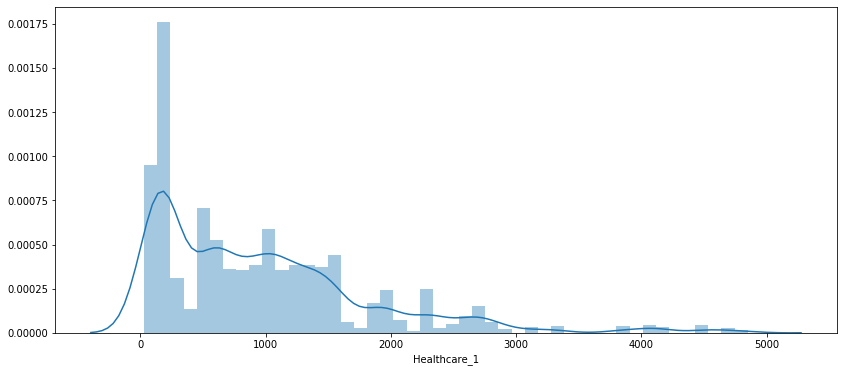

In [63]:
plt.figure(figsize=(14, 6))
sns.distplot(train.Healthcare_1);

In [64]:
test_drops = test.loc[test['Healthcare_1'].isnull()]
test_preds = filling_drops.predict(test_drops.drop('Healthcare_1', axis=1))
test.loc[test['Healthcare_1'].isnull(), 'Healthcare_1'] = test_preds

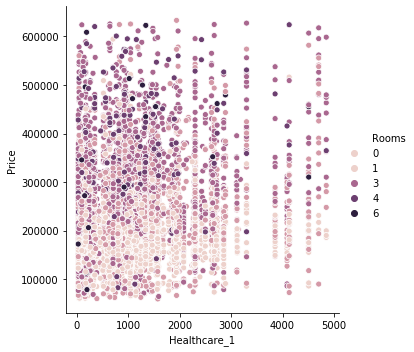

In [65]:
sns.relplot(x="Healthcare_1", y="Price", hue="Rooms", data=train);

### 'Social_1'

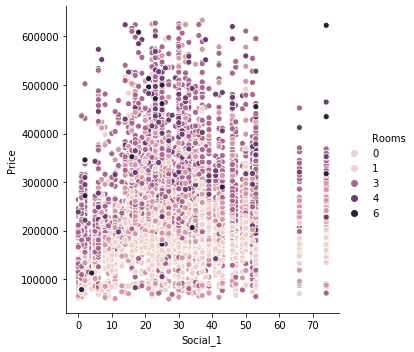

In [66]:
sns.relplot(x="Social_1", y="Price", hue="Rooms", data=train);

### 'Social_2'

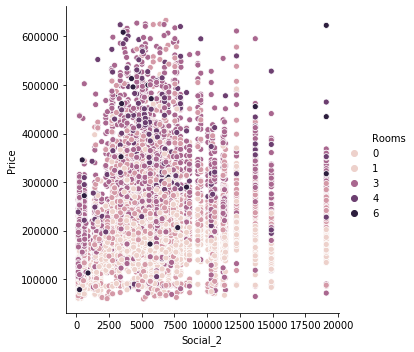

In [67]:
sns.relplot(x="Social_2", y="Price", hue="Rooms", data=train);

### 'Social_3'

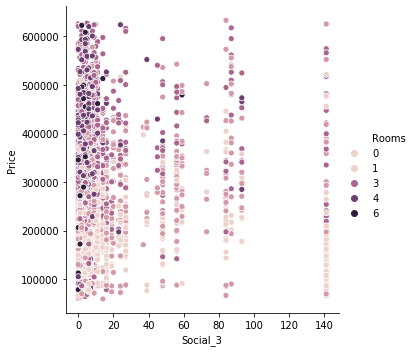

In [68]:
sns.relplot(x="Social_3", y="Price", hue="Rooms", data=train);

### 'Helthcare_2'

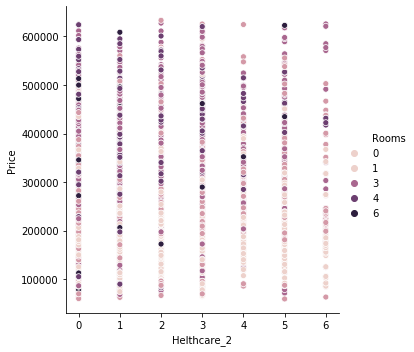

In [69]:
sns.relplot(x="Helthcare_2", y="Price", hue="Rooms", data=train);

### 'Shops_1'

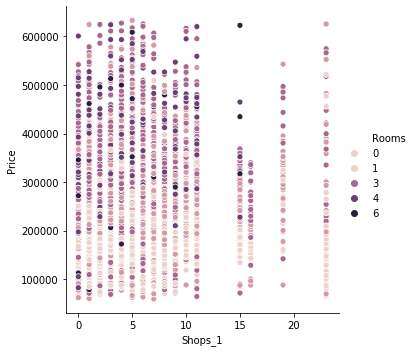

In [70]:
sns.relplot(x="Shops_1", y="Price", hue="Rooms", data=train);

In [71]:
cat_features

['Ecology_2', 'Ecology_3', 'Shops_2']

In [72]:
train['Ecology_2'].value_counts()

B    9903
A      97
Name: Ecology_2, dtype: int64

In [73]:
train['Ecology_2'] = (train['Ecology_2'] == 'A').astype(int)

In [74]:
train['Ecology_3'].value_counts()

B    9725
A     275
Name: Ecology_3, dtype: int64

In [75]:
train['Ecology_3'] = (train['Ecology_3'] == 'A').astype(int)

In [76]:
train['Shops_2'].value_counts()

B    9175
A     825
Name: Shops_2, dtype: int64

In [77]:
train['Shops_2'] = (train['Shops_2'] == 'A').astype(int)

In [78]:
test['Ecology_2'] = (test['Ecology_2'] == 'A').astype(int)
test['Ecology_3'] = (test['Ecology_3'] == 'A').astype(int)
test['Shops_2'] = (test['Shops_2'] == 'A').astype(int)

In [79]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10000 entries, 0 to 9999
Data columns (total 23 columns):
Id               10000 non-null int64
DistrictId       10000 non-null int64
Rooms            10000 non-null int32
Square           10000 non-null float64
LifeSquare       10000 non-null float64
KitchenSquare    10000 non-null int32
Floor            10000 non-null int32
HouseFloor       10000 non-null int32
HouseYear        10000 non-null int32
Ecology_1        10000 non-null float64
Ecology_2        10000 non-null int32
Ecology_3        10000 non-null int32
Social_1         10000 non-null float64
Social_2         10000 non-null float64
Social_3         10000 non-null float64
Healthcare_1     10000 non-null float64
Helthcare_2      10000 non-null float64
Shops_1          10000 non-null float64
Shops_2          10000 non-null int32
Price            10000 non-null float64
MeanPrice        10000 non-null float64
IsGroundFloor    10000 non-null int64
IsUpperFloor     10000 non-null in

In [80]:
basic_features = train.columns.drop(['Price', 'Id', 'DistrictId']).to_list()

In [81]:
basic_features

['Rooms',
 'Square',
 'LifeSquare',
 'KitchenSquare',
 'Floor',
 'HouseFloor',
 'HouseYear',
 'Ecology_1',
 'Ecology_2',
 'Ecology_3',
 'Social_1',
 'Social_2',
 'Social_3',
 'Healthcare_1',
 'Helthcare_2',
 'Shops_1',
 'Shops_2',
 'MeanPrice',
 'IsGroundFloor',
 'IsUpperFloor']

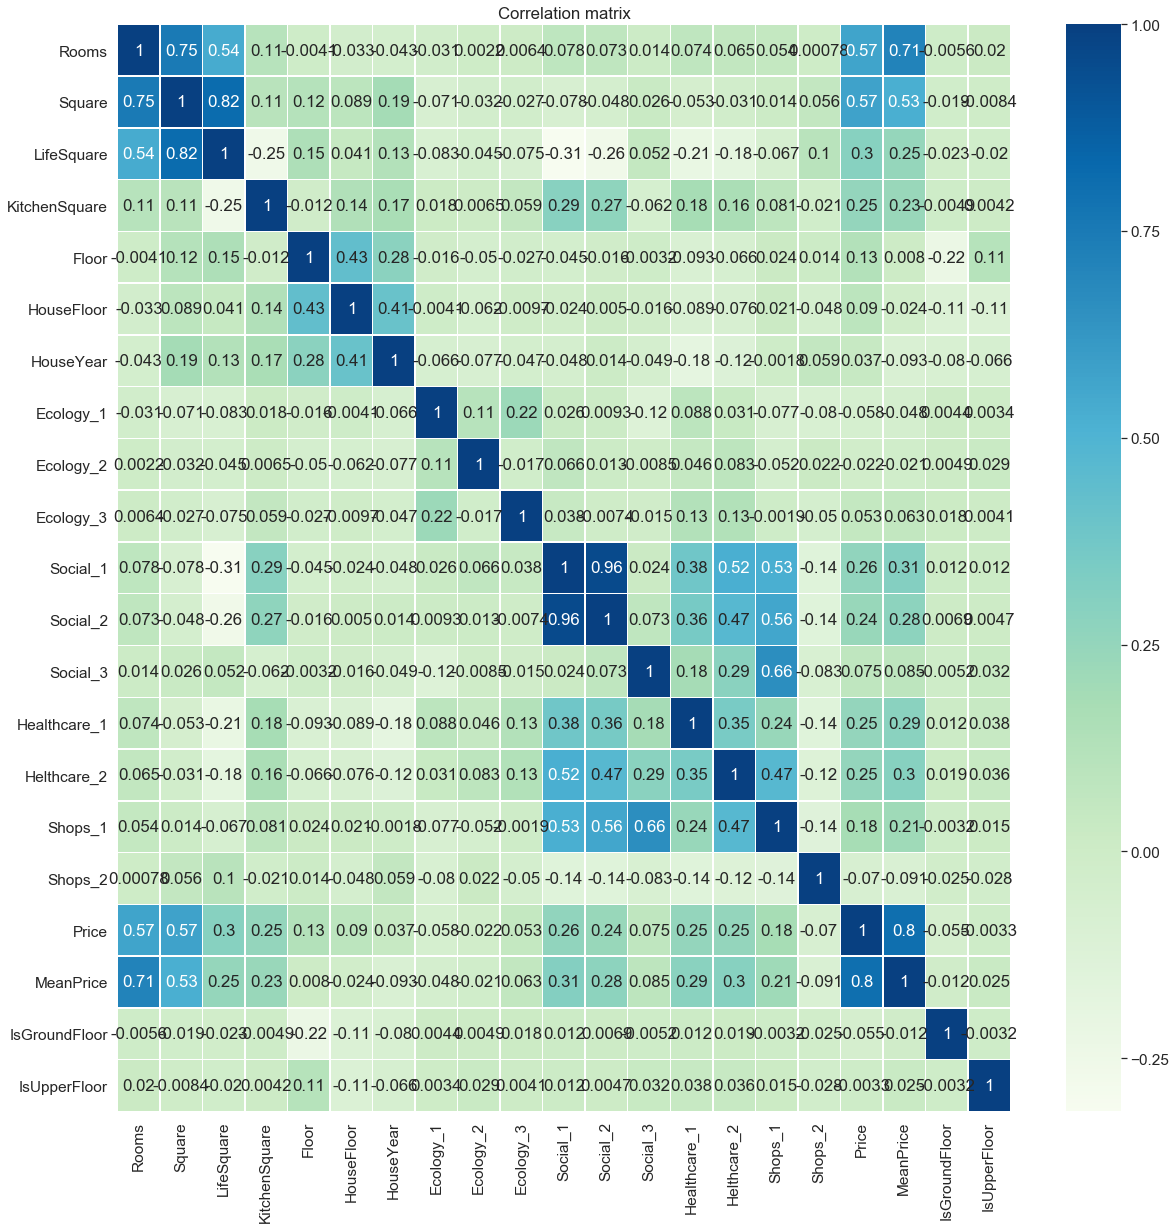

In [82]:
plt.figure(figsize=(20,20))

sns.set(font_scale=1.4)
sns.heatmap(train.drop(columns=['Id', 'DistrictId']).corr(), annot=True, linewidths=.5, cmap='GnBu')

plt.title('Correlation matrix')
plt.show()

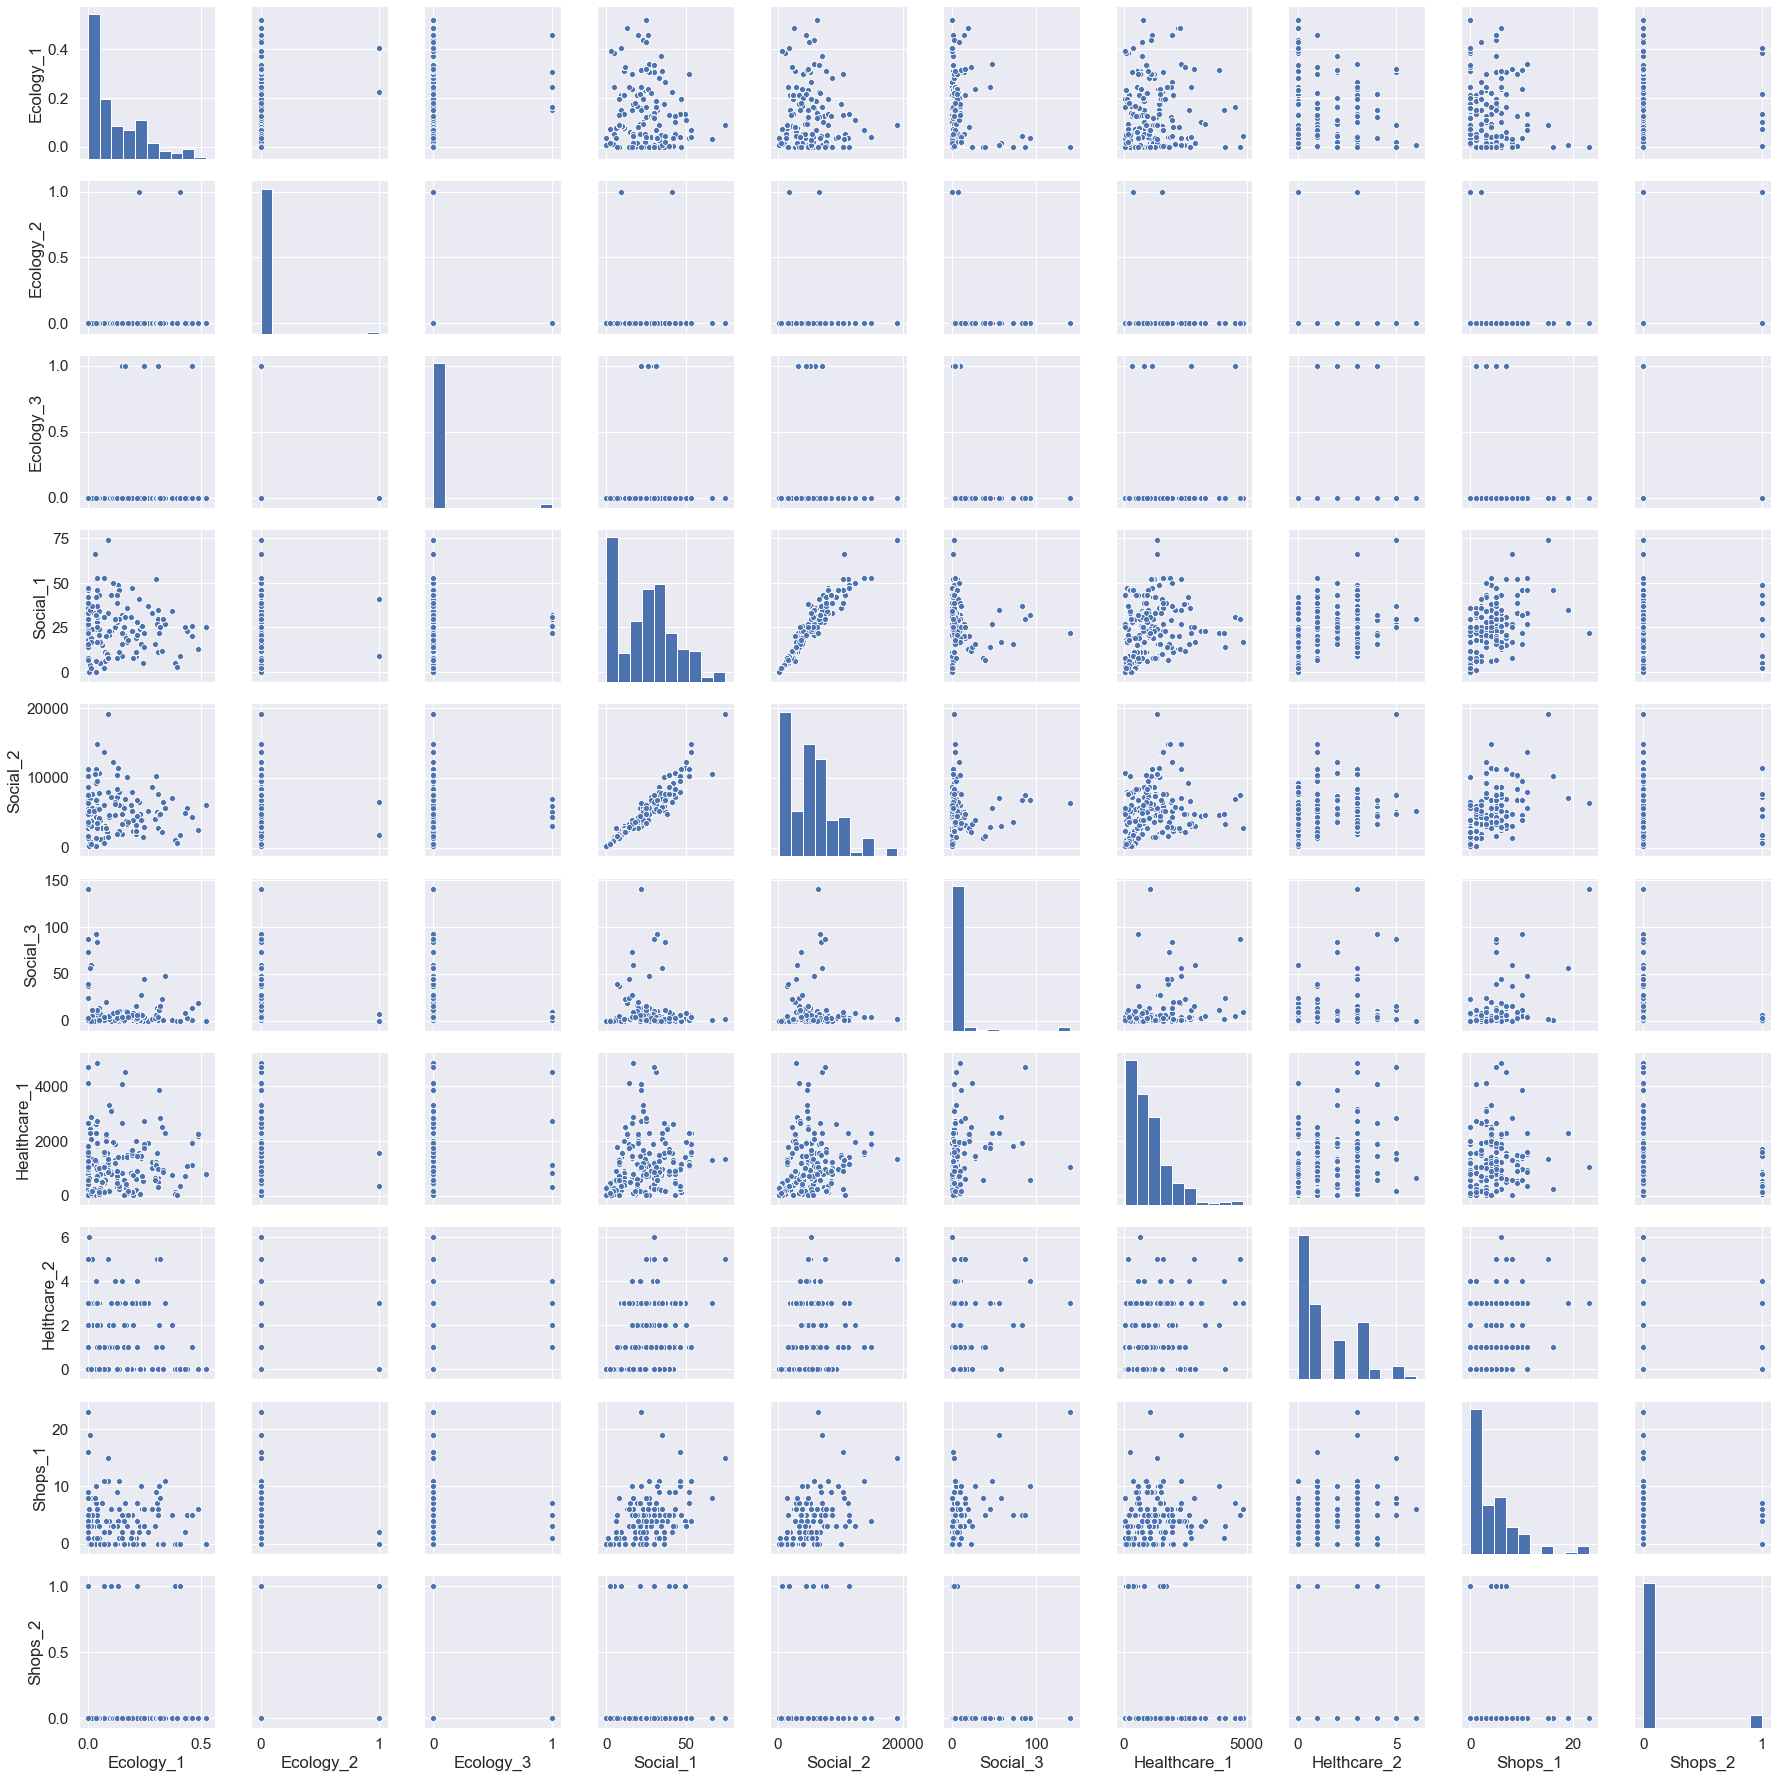

In [83]:
sns.pairplot(train[['Ecology_1',
 'Ecology_2',
 'Ecology_3',
 'Social_1',
 'Social_2',
 'Social_3',
 'Healthcare_1',
 'Helthcare_2',
 'Shops_1',
 'Shops_2']], size=2.5)
plt.tight_layout();

### Сохранение данных

In [84]:
PREPROCESSED_TRAIN_DATASET_PATH = 'prep_train.csv'
PREPROCESSED_TEST_DATASET_PATH = 'prep_test.csv'

In [85]:
train.to_csv(PREPROCESSED_TRAIN_DATASET_PATH, index=None)

In [86]:
test.to_csv(PREPROCESSED_TEST_DATASET_PATH, index=None)

#### Разбиение данных на train и valid

In [87]:
X = train[basic_features]
y = train['Price']

In [88]:
from sklearn.model_selection import train_test_split

In [89]:
X_train, X_validation, y_train, y_validation = train_test_split(X, y, train_size=0.80, shuffle=True, random_state=42)

In [90]:
from sklearn.preprocessing import MinMaxScaler

In [91]:
scaler = MinMaxScaler()

In [92]:
# X_train = scaler.fit_transform(X_train)
# X_validation = scaler.transform(X_validation)

In [93]:
# test[basic_features] = scaler.transform(test[basic_features])

# Выбор модели

In [94]:
def train_model(model, X_train, y_train, X_test, y_test):
    '''
    Модель обучается на трейне, предсказывает на трейне и тесте, 
    выдает значения RMSE и R2 для трейна и теста
    '''
    model.fit(X_train, y_train)
    y_pred_train = model.predict(X_train)
    y_pred_test = model.predict(X_test)
    
    print("train_RMSE: {}".format(np.sqrt(mean_squared_error((y_train), (y_pred_train)))))
    print("test_RMSE: {}".format(np.sqrt(mean_squared_error((y_test), (y_pred_test)))))
    print()
    print("train_R2: {}".format(r2_score((y_train), (y_pred_train))))
    print("test_R2: {}".format(r2_score((y_test), (y_pred_test))))

# RandomForestRegressor

In [95]:
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor

In [96]:
rf = RandomForestRegressor(n_jobs=-1, 
                              n_estimators=1000, 
                              random_state=5, 
                              oob_score=True, 
                              warm_start=True,
                              bootstrap=True, 
                              min_samples_leaf=5, 
                              max_features=6)

In [97]:
train_model(rf, X_train, y_train, X_validation, y_validation)

train_RMSE: 33372.96116219577
test_RMSE: 43669.851761773265

train_R2: 0.8718825374466439
test_R2: 0.7714907563932918


In [98]:
rf.oob_score_

0.7687702801438527

In [99]:
feature_importances = pd.DataFrame({'feature': X_train.columns, 'importance': rf.feature_importances_})
feature_importances = feature_importances.sort_values('importance', ascending=False)
feature_importances

,feature,importance
17,MeanPrice,0.381838
1,Square,0.199135
0,Rooms,0.083932
2,LifeSquare,0.050830
11,Social_2,0.049945
10,Social_1,0.045786
12,Social_3,0.038632
3,KitchenSquare,0.030789
6,HouseYear,0.024190
13,Healthcare_1,0.022501


In [100]:
lasso = LassoCV(random_state=1, normalize=True)

In [101]:
train_model(lasso, X_train, y_train, X_validation, y_validation)

train_RMSE: 49441.30191125524
test_RMSE: 48270.92011451931

train_R2: 0.718810798117407
test_R2: 0.7208025215205524


In [104]:
pd.DataFrame(lasso.coef_, index=X_train.columns, 
                       columns=['weight']).sort_values(by='weight', ascending=False)

,weight
Square,2154.064399
Floor,1459.497338
Ecology_3,1264.383268
Helthcare_2,1212.711290
Social_1,585.224934
HouseFloor,414.847806
KitchenSquare,127.331234
Social_3,62.551525
HouseYear,30.285870
Healthcare_1,4.976592


In [105]:
best_features = X_train.drop('Ecology_2', axis=1).columns.to_list()

In [109]:
%%time
rgr = RandomForestRegressor(n_jobs=-1, 
                              n_estimators=5000, 
                              random_state=5, 
                              oob_score=True, 
                              warm_start=True,
                              bootstrap=True
                              )

param_grid = {
    'max_features': np.arange(4, 7),
    'min_samples_split': np.arange(3, 6),
    'min_samples_leaf': np.arange(3, 6)        
}

grid_search = RandomizedSearchCV(rgr, param_grid, n_jobs=-1, cv=10, n_iter=50)

Wall time: 0 ns


In [110]:
train_model(grid_search, X_train, y_train, X_validation, y_validation)

train_RMSE: 28323.210259224677
test_RMSE: 43294.65947088345

train_R2: 0.9077208054286321
test_R2: 0.7754003922047525


In [111]:
grid_search.best_params_

{'min_samples_split': 3, 'min_samples_leaf': 3, 'max_features': 6}

In [112]:
grid_search.best_score_

0.7720522286903558

## XGBRegressor

In [113]:
xgbr = xgb.XGBRegressor(random_state=1, objective='reg:squarederror', n_jobs=-1)

In [114]:
train_model(xgbr, X_train, y_train, X_validation, y_validation)

train_RMSE: 41974.00764644884
test_RMSE: 45247.4073093872

train_R2: 0.7973345501114992
test_R2: 0.7546829489339344


In [115]:
model = xgb.XGBRegressor(random_seed=5, objective='reg:squarederror', n_jobs=-1)

grid = {
    'learning_rate': np.linspace(0.01, 0.7, 10),
    'depth': np.arange(3, 8),
    'reg_alpha': np.linspace(0.0, 1.0, 10),
    'reg_lambda': np.arange(3, 12),
    'gamma': np.linspace(0.0, 1.0, 10)
}

gscv = RandomizedSearchCV(model, grid, n_jobs=-1, cv=10, n_iter=50)

In [116]:
train_model(gscv, X_train, y_train, X_validation, y_validation)

train_RMSE: 37263.85292097108
test_RMSE: 44850.294393996395

train_R2: 0.8402671073081416
test_R2: 0.7589700928434945


In [117]:
gscv.best_params_

{'reg_lambda': 11,
 'reg_alpha': 0.2222222222222222,
 'learning_rate': 0.3933333333333333,
 'gamma': 0.7777777777777777,
 'depth': 5}

# Предсказание

In [118]:
# preds = np.exp(grid_search.predict(test[best_features]))

In [119]:
# test['Price'] = preds
# test.loc[:, ['Id', 'Price']].to_csv('ATaganova_predictions.csv', index=None)